## Libraries, etc.

In [214]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import numpy as np
from projects.iam.energy_system import LogitEnergySystem

warnings.filterwarnings("ignore")
%load_ext jupyter_black

The jupyter_black extension is already loaded. To reload it, use:
  %reload_ext jupyter_black


### Paths to files

In [218]:
GCCSI = "/Volumes/Samsung_T5/data/buildout/co2re_facilities_table_20241028.csv"
IEA_CCUS = "/Users/lindseygulden/Downloads/IEA_CCUS_Projects_Database_2024.xlsx"
IEA_SHEET_NAME = "CCUS Projects Database"
EPA_CLASS_VI = "/Volumes/Samsung_T5/data/buildout/epa_class_vi_uic_permitting_database_downloaded_10_27_2024.csv"

In [219]:
## EPA Class VI permit database for  US
epa_df = pd.read_csv(EPA_CLASS_VI)
epa_df

,Applicant Name,Project Name,Well Applications,EPA Region,State,County/Tribe,Application Received Date,NOD 1 Sent,NOD 1 Response Rec'd,NOD 2 Sent,...,Draft Permit - Actual Date,Public Comment Period - Estimated Date,Public Comment Period - Actual Date,Final Permit Decision- Estimated Date,Final Permit Decision- Actual Date,2nd Public Comment Period - Estimated,2nd Public Comment Period - Actual,2nd Prepare Final Permit Decision - Estimated,2nd Prepare Final Permit Decision - Actual,24 Month Goal Date
0,"Carbon TerraVault I, LLC",CTV Elk Hills A1-A2,2,9,California,Kern,8/30/2021,-,-,-,...,-,12/31/2024,-,-,-,-,-,-,-,9/20/2023
1,"Carbon TerraVault I, LLC",Elk Hills 26R,4,9,California,Kern,11/5/2021,-,-,-,...,12/20/2023,-,3/20/2024,-,7/11/2024,-,8/12/2024,12/6/2024,-,12/9/2023
2,"Lorain Carbon Zero Solutions, LLC",Lorain CCS,1,5,Ohio,Lorain,12/29/2021,-,-,-,...,-,5/15/2025,-,-,-,-,-,-,-,1/28/2024
3,"Oxy Low Carbon Ventures, LLC",Brown Pelican,3,6,Texas,Ector,5/2/2022,-,-,-,...,9/3/2024,11/6/2024,-,2/14/2025,-,-,-,-,-,6/20/2024
4,"Carbon TerraVault Holdings, LLC",CTV II,5,9,California,San Joaquin,5/3/2022,6/10/2022,8/4/2022,9/21/2022,...,-,7/14/2025,-,-,-,-,-,-,-,2/22/2025
5,"Carbon TerraVault Holdings, LLC",CTV III,6,9,California,San Joaquin,5/3/2022,6/10/2022,8/4/2022,9/21/2022,...,-,4/15/2025,-,-,-,-,-,-,-,1/29/2025
6,"Marquis Carbon Injection, LLC",Marquis Carbon,1,5,Illinois,Putnam,5/12/2022,6/6/2022,-,-,...,-,1/30/2025,-,-,-,-,-,-,-,7/21/2024
7,"Heartland Greenway Carbon Storage, LLC",Heartland Greenway,6,5,Illinois,Christian,7/6/2022,8/5/2022,-,10/19/2022,...,-,2/14/2025,-,-,-,-,-,-,-,1/29/2025
8,"One Carbon Partnership, LP",Hoosier #1,1,5,Indiana,Randolph,9/15/2022,10/11/2022,-,-,...,-,3/17/2025,-,-,-,-,-,-,-,12/12/2024
9,"One Earth Sequestration, LLC",One Earth CCS,3,5,Illinois,Ford,10/28/2022,11/23/2022,-,-,...,-,4/14/2025,-,-,-,-,-,-,-,1/17/2025


## Global CCS Institute CO2RE database

In [220]:
gci_df = pd.read_csv(GCCSI)
gci_df.columns = [x.lower().replace("facility ", "") for x in gci_df.columns.values]
gci_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 774 entries, 0 to 773
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   name         774 non-null    object
 1   category     774 non-null    object
 2   status       766 non-null    object
 3   location     773 non-null    object
 4   operational  751 non-null    object
 5   industry     765 non-null    object
 6   description  604 non-null    object
dtypes: object(7)
memory usage: 42.5+ KB


In [289]:
catf_df.loc[catf_df.eor == 1].project_name.values()

AttributeError: 'DataFrame' object has no attribute 'eor'

In [221]:
gci_df.operational.unique()
beyond = "2033"
gci_df["operational_raw"] = gci_df["operational"].copy()
gci_df["operational"] = gci_df["operational"].fillna(beyond)
gci_df["operational"] = [
    beyond if x == "Under Evaluation" else x for x in gci_df.operational
]
gci_df["operational"] = gci_df["operational"].astype(int)
operational_order = sorted(list(gci_df["operational"].unique()))

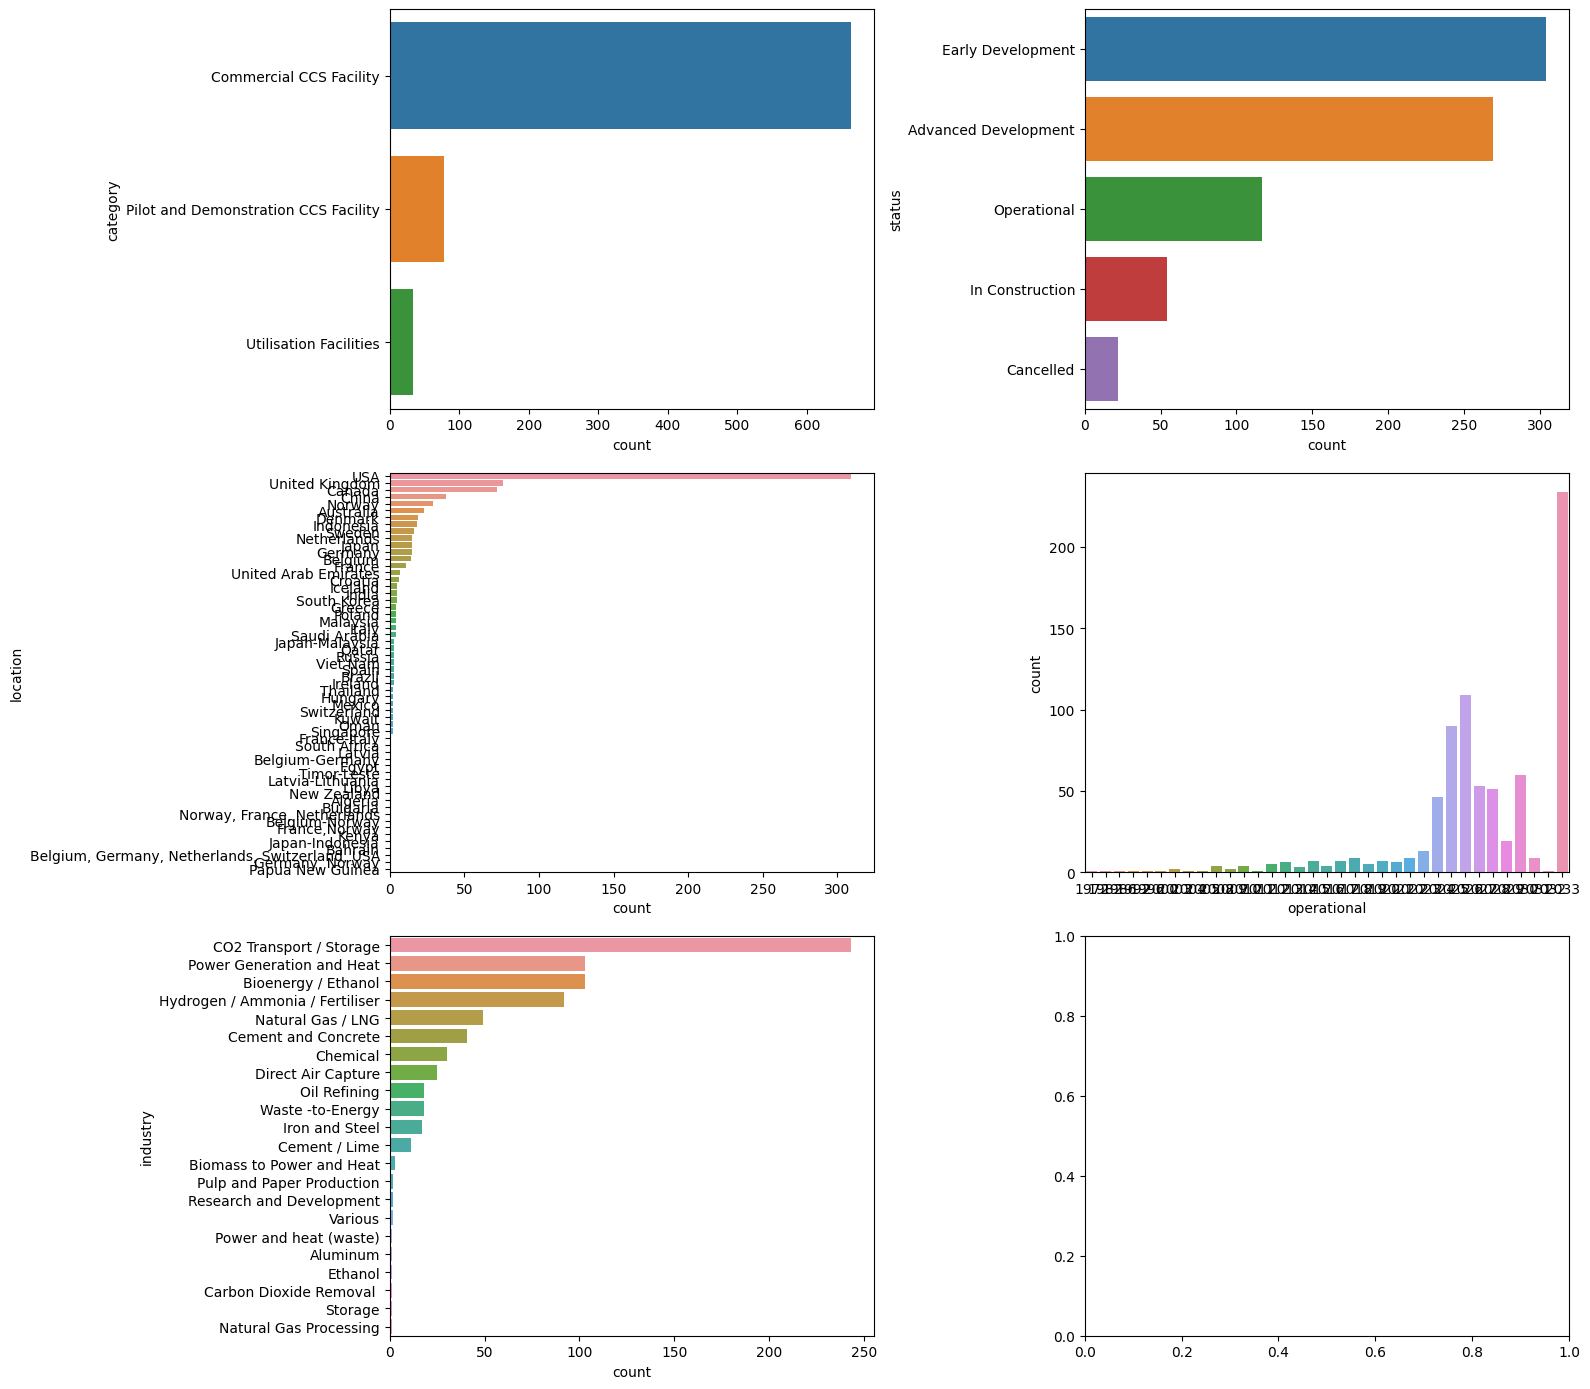

In [222]:
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
for i, v in enumerate(["category", "status", "location", "operational", "industry"]):
    plt.subplot(3, 2, i + 1)
    plot_df = pd.DataFrame(gci_df[v].value_counts()).reset_index()
    if v == "operational":
        sns.barplot(data=plot_df, x=v, y="count", order=operational_order)
    else:
        sns.barplot(data=plot_df, y=v, x="count")
fig.tight_layout()

## IEA CCUS database 

In [435]:
# Read data, compile references into a single column, remove link and single-reference columns
iea_df = pd.read_excel(
    IEA_CCUS,
    sheet_name=IEA_SHEET_NAME,
)

iea_df[["Ref 1", "Ref 2", "Ref 3", "Ref 4", "Ref 5", "Ref 6", "Ref 7"]].fillna(
    "", inplace=True
)
iea_df["references"] = [
    str(r1)
    + " "
    + str(r2)
    + " "
    + str(r3)
    + " "
    + str(r4)
    + " "
    + str(r5)
    + " "
    + str(r6)
    + " "
    + str(r7)
    for r1, r2, r3, r4, r5, r6, r7 in zip(
        iea_df["Ref 1"],
        iea_df["Ref 2"],
        iea_df["Ref 3"],
        iea_df["Ref 4"],
        iea_df["Ref 5"],
        iea_df["Ref 6"],
        iea_df["Ref 7"],
    )
]
iea_df.drop(
    [
        "Ref 1",
        "Ref 2",
        "Ref 3",
        "Ref 4",
        "Ref 5",
        "Ref 6",
        "Ref 7",
        "Link 1",
        "Link 2",
        "Link 3",
        "Link 4",
        "Link 5",
        "Link 6",
        "Link 7",
    ],
    axis=1,
    inplace=True,
)
iea_df.columns = [
    x.lower().replace("(", "").replace(")", "").replace("/", "_per_").replace(" ", "_")
    for x in iea_df.columns.values
]

In [436]:
iea_df

,project_name,id,country,partners,project_type,announcement,fid,operation,suspension_per_decommissioning,project_status,project_phase,announced_capacity_mt_co2_per_yr,estimated_capacity_by_iea_mt_co2_per_yr,sector,fate_of_carbon,part_of_ccus_hub,region,references
0,3D DMX ArcelorMittal and IFPEN Dunkirk (full-s...,1,France,"ArcelorMittal, ifp, Axens, Uetikon, Grassco, b...",Capture,2019.0,NaN,2025.0,NaN,Planned,2.0,0.7,0.70,Iron and steel,Unknown/unspecified,NaN,Europe,https://automotive.arcelormittal.com/news_and_...
1,3D DMX ArcelorMittal and IFPEN Dunkirk 'REUZE',751,France,"ArcelorMittal, Engie, Infinium",CCU,2022.0,2024.0,2025.0,NaN,Planned,1.0,0.3,0.30,Iron and steel,Use,NaN,Europe,https://newsroom.engie.com/actualites/engie-et...
2,7 Blue Ammonia Facility,1055,Qatar,"QAFCO, thyssenkrupp Uhde/Consolidated Contract...",Full Chain,2022.0,2022.0,2026.0,NaN,Under construction,NaN,1.5,1.50,Hydrogen or ammonia,Unknown/unspecified,NaN,Middle East,https://www.qafco.qa/content/qafco-7-announcem...
3,8Rivers H2 (8RH2) (WY),3,United States,"8Rivers, Wyoming Energy Authority",Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Hydrogen or ammonia,Dedicated storage,NaN,North America,https://8rivers.com/portfolio/8-rivers-hydroge...
4,Abadi CCS/CCUS,227,Indonesia,"Inpex Masela 65%, Shell (trying to find a buye...",Full chain,2018.0,NaN,2027.0,NaN,Planned,NaN,2.41,2.41,Natural gas processing/LNG,Unknown/unspecified,NaN,Other Asia Pacific,https://www.upstreamonline.com/lng/inpex-furth...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839,Yara Pilbara ammonia,788,Australia,"Yara, JERA",Capture,2021.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Hydrogen or ammonia,Unknown/unspecified,NaN,Australia and New Zealand,https://www.yara.com/corporate-releases/yara-a...
840,Yara Sluiskil fertiliser,465,Netherlands,Yara,Capture,2022.0,2023.0,2026.0,NaN,Under construction,NaN,0.8,0.80,Chemicals,Dedicated storage,Northern Lights,Europe,https://norlights.com/news/major-milestone-for...
841,Yara-BASF Gulf Coast,826,United States,"Yara, BASF",Capture,2023.0,NaN,2028.0,NaN,Planned,NaN,NaN,2.10,Hydrogen or ammonia,Unknown/unspecified,NaN,North America,https://www.basf.com/global/en/media/news-rele...
842,ZerCal250,640,United Kingdom,"Origin, Singleton Birch",Capture,2021.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Cement,Dedicated storage,Northern Endurance Partnership,Europe,https://birchchemicals.co.uk/birch-chemicals-b...


In [437]:
iea_df.loc[iea_df.country == "United States"]

,project_name,id,country,partners,project_type,announcement,fid,operation,suspension_per_decommissioning,project_status,project_phase,announced_capacity_mt_co2_per_yr,estimated_capacity_by_iea_mt_co2_per_yr,sector,fate_of_carbon,part_of_ccus_hub,region,references
3,8Rivers H2 (8RH2) (WY),3,United States,"8Rivers, Wyoming Energy Authority",Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Hydrogen or ammonia,Dedicated storage,NaN,North America,https://8rivers.com/portfolio/8-rivers-hydroge...
5,Ackerman Combined Cycle Plant (MS),975,United States,"Trifecta Renewable Solutions, Tennessee Valley...",Capture,2023.0,NaN,NaN,NaN,Planned,NaN,1.8,1.800,Power and heat,Dedicated storage,Red Hills CO2 storage hub (MS),North America,https://www.energy.gov/fecm/project-selections...
11,Adams Fork Energy clean ammonia project (WV),1033,United States,"Adams Fork Energy, the Flandreau Santee Sioux ...",Capture,2022.0,2024.0,NaN,NaN,Planned,NaN,NaN,3.591,Hydrogen or ammonia,Unknown/unspecified,NaN,North America,https://adamsforkenergy.com/ https://investors...
13,ADM Cedar rapids bioethanol (IA),13,United States,ADM,Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...
14,ADM Clinton bioethanol (IA),14,United States,ADM,Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Wabash Valley Resources/Wabash CarbonSAFE (IN),406,United States,"Wabash Valley Resources, Wabash Carbon service...",Full chain,2016.0,NaN,2024.0,NaN,Planned,NaN,1.65,1.650,Hydrogen or ammonia,Dedicated storage,Wabash CarbonSAFE (IN),North America,https://www.netl.doe.gov/projects/project-info...
824,West bay storage Galveston (TX),1050,United States,BP carbon solutions,Storage,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Storage,Dedicated storage,West bay storage Galveston (TX),North America,https://www.epa.gov/uic/current-class-vi-proje...
828,Whiting Refinery,980,United States,BP Carbon Solutions LLC,Capture,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Other fuel transformation,Dedicated storage,"Project Crossroads (IN, IL, MI)",North America,https://www.energy.gov/fecm/project-selections...
830,William Echo Springs CarbonSAFE (WY),959,United States,"University of Wyoming, Williams",Storage,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,1.667,Storage,Dedicated storage,William Echo Springs CarbonSAFE (WY),North America,https://www.uwyo.edu/ser/news/2023/11/echo-spr...


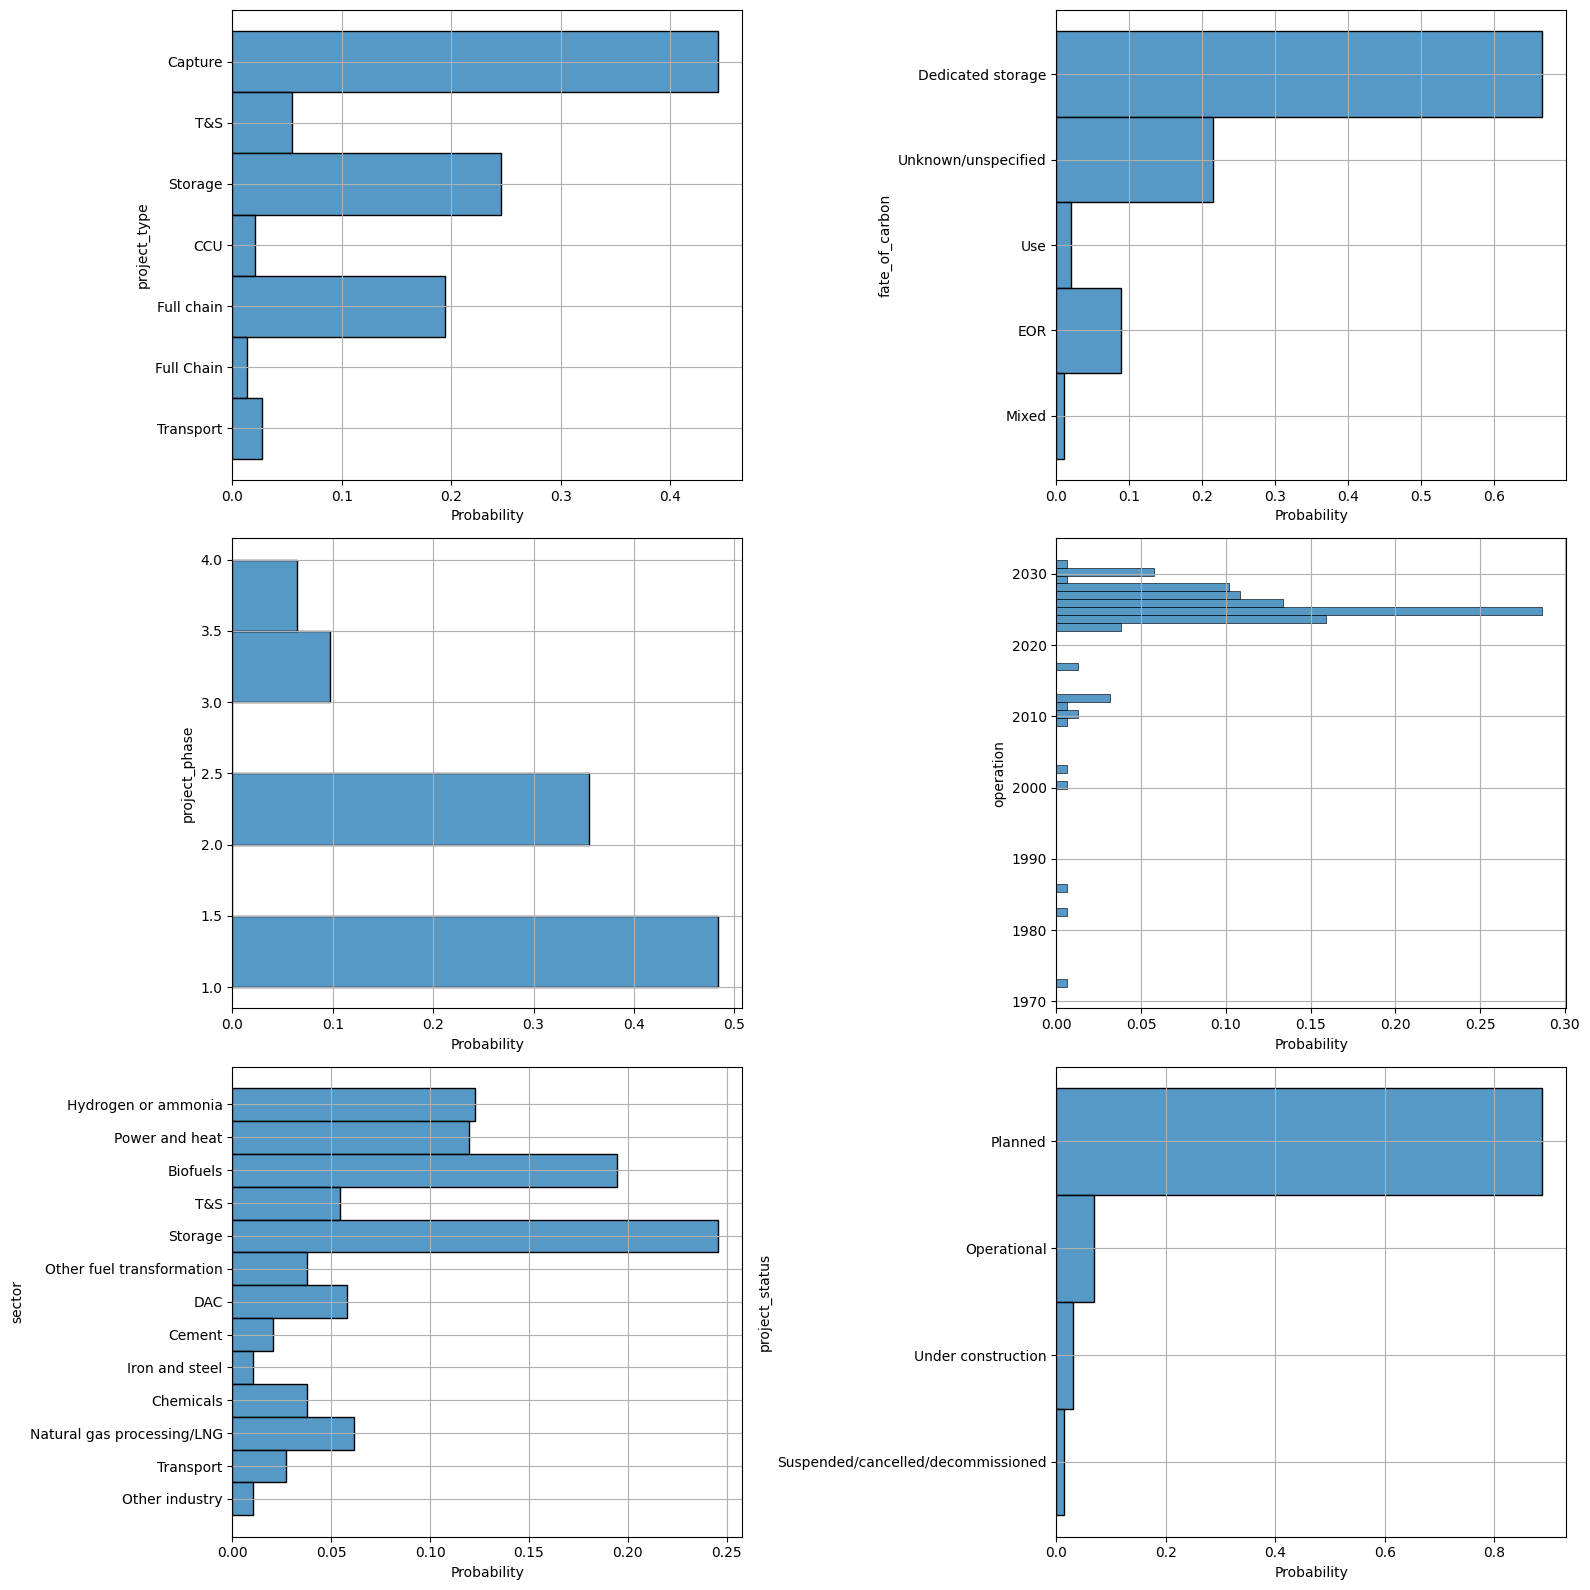

In [228]:
cols = [
    "project_type",
    "fate_of_carbon",
    "project_phase",
    "operation",
    "sector",
    "project_status",
]
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
for i, ax in enumerate(axes.reshape(-1)):
    sns.histplot(
        data=iea_df.loc[iea_df.country == "United States"],
        y=cols[i],
        ax=ax,
        # hue="region",
        multiple="dodge",
        stat="probability",
    )
    ax.grid()
fig.tight_layout()

In [439]:
iea_us_df = iea_df.loc[iea_df.country == "United States"].copy()
iea_names = sorted(list(iea_us_df.project_name.unique()))
iea_us_df.columns.values

array(['project_name', 'id', 'country', 'partners', 'project_type',
       'announcement', 'fid', 'operation',
       'suspension_per_decommissioning', 'project_status',
       'project_phase', 'announced_capacity_mt_co2_per_yr',
       'estimated_capacity_by_iea_mt_co2_per_yr', 'sector',
       'fate_of_carbon', 'part_of_ccus_hub', 'region', 'references'],
      dtype=object)

In [441]:
iea_us_df

,project_name,id,country,partners,project_type,announcement,fid,operation,suspension_per_decommissioning,project_status,project_phase,announced_capacity_mt_co2_per_yr,estimated_capacity_by_iea_mt_co2_per_yr,sector,fate_of_carbon,part_of_ccus_hub,region,references
3,8Rivers H2 (8RH2) (WY),3,United States,"8Rivers, Wyoming Energy Authority",Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Hydrogen or ammonia,Dedicated storage,NaN,North America,https://8rivers.com/portfolio/8-rivers-hydroge...
5,Ackerman Combined Cycle Plant (MS),975,United States,"Trifecta Renewable Solutions, Tennessee Valley...",Capture,2023.0,NaN,NaN,NaN,Planned,NaN,1.8,1.800,Power and heat,Dedicated storage,Red Hills CO2 storage hub (MS),North America,https://www.energy.gov/fecm/project-selections...
11,Adams Fork Energy clean ammonia project (WV),1033,United States,"Adams Fork Energy, the Flandreau Santee Sioux ...",Capture,2022.0,2024.0,NaN,NaN,Planned,NaN,NaN,3.591,Hydrogen or ammonia,Unknown/unspecified,NaN,North America,https://adamsforkenergy.com/ https://investors...
13,ADM Cedar rapids bioethanol (IA),13,United States,ADM,Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...
14,ADM Clinton bioethanol (IA),14,United States,ADM,Capture,2022.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
818,Wabash Valley Resources/Wabash CarbonSAFE (IN),406,United States,"Wabash Valley Resources, Wabash Carbon service...",Full chain,2016.0,NaN,2024.0,NaN,Planned,NaN,1.65,1.650,Hydrogen or ammonia,Dedicated storage,Wabash CarbonSAFE (IN),North America,https://www.netl.doe.gov/projects/project-info...
824,West bay storage Galveston (TX),1050,United States,BP carbon solutions,Storage,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Storage,Dedicated storage,West bay storage Galveston (TX),North America,https://www.epa.gov/uic/current-class-vi-proje...
828,Whiting Refinery,980,United States,BP Carbon Solutions LLC,Capture,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,NaN,Other fuel transformation,Dedicated storage,"Project Crossroads (IN, IL, MI)",North America,https://www.energy.gov/fecm/project-selections...
830,William Echo Springs CarbonSAFE (WY),959,United States,"University of Wyoming, Williams",Storage,2023.0,NaN,NaN,NaN,Planned,NaN,NaN,1.667,Storage,Dedicated storage,William Echo Springs CarbonSAFE (WY),North America,https://www.uwyo.edu/ser/news/2023/11/echo-spr...


In [440]:
iea_us_df["fate_of_carbon"] = iea_us_df["fate_of_carbon"].fillna("Unknown/unspecified")
iea_us_df["description"] = iea_us_df["description"].fillna("")
iea_us_df["eor"] = [
    1
    if (f == "EOR")
    | ("oil recovery" in x.lower())
    | ("eor" in x.lower())
    | ("oil field" in x.lower())
    | ("oil unit" in x.lower())
    | ("oil reservoir" in x.lower())
    | ("oil and gas reservoir" in x.lower())
    | ("gas field" in x.lower())
    | ("lea county" in x.lower())
    | ("oil and gas field" in x.lower())
    else 0
    for f, x in zip(iea_us_df.fate_of_carbon, iea_us_df.description)
]
iea_us_df.eor.value_counts()

KeyError: 'description'

In [230]:
gci_us_df = gci_df.loc[gci_df.location == "USA"]
gci_names = sorted(list(gci_us_df.name.unique()))

In [234]:
mapping_df = pd.read_csv(
    "/Users/lindseygulden/dev/leg-up-private/projects/buildout/mapping_gci_iea.csv"
)
mapping_df.columns = [x + "_name" for x in mapping_df.columns.values]

In [235]:
df = gci_us_df.merge(
    mapping_df, left_on="name", right_on="gci_name", how="outer"
).merge(iea_us_df, left_on="iea_name", right_on="project_name", how="outer")

In [236]:
df["estimated_capacity_by_iea_mt_co2_per_yr"].sum()

943.523

In [237]:
# df = df.loc[(df.gci_name.notna()) & (df.iea_name.notna())]
df.drop(["name", "project_name", "location", "country"], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 24 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   category                                 322 non-null    object 
 1   status                                   321 non-null    object 
 2   operational                              322 non-null    float64
 3   industry                                 320 non-null    object 
 4   description                              252 non-null    object 
 5   operational_raw                          318 non-null    object 
 6   gci_name                                 323 non-null    object 
 7   iea_name                                 313 non-null    object 
 8   id                                       296 non-null    float64
 9   partners                                 296 non-null    object 
 10  project_type                             296 non-n

<Axes: xlabel='estimated_capacity_by_iea_mt_co2_per_yr', ylabel='Count'>

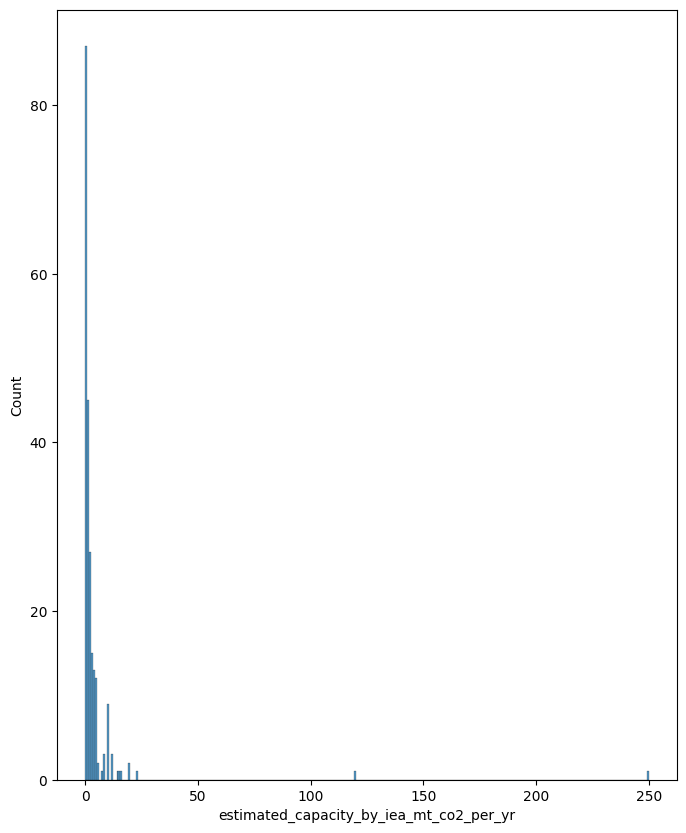

In [238]:
fig, ax = plt.subplots(1, 1, figsize=(8, 10))
sns.histplot(
    data=df[["sector", "estimated_capacity_by_iea_mt_co2_per_yr"]].dropna(),
    x="estimated_capacity_by_iea_mt_co2_per_yr",
)

In [94]:
df.part_of_ccus_hub.value_counts()

part_of_ccus_hub
Midwest carbon express                                                                  34
CO2NNECTION Central Appalachian Basin hub/Appalachian basin storage MoU (OH, PA, WV)     6
Sweetwater Carbon Storage Hub (WY)                                                       5
Venture Global CCS Cameron (LA)                                                          4
Central Louisiana Regional Carbon Storage (CENLA) Hub (LA)                               4
                                                                                        ..
Illinois Basin West CarbonSAFE (IL)                                                      1
Denbury NEJD Pipeline (MS-LA)/Leo (MS)                                                   1
ExxonMobil Vermilion parish storage                                                      1
Lone Star Storage Hub Project (Jasper) (TX)                                              1
William Echo Springs CarbonSAFE (WY)                                     

In [98]:
df.loc[df.iea_name.notna()].estimated_capacity_by_iea_mt_co2_per_yr.isna().sum()

95

In [105]:
df.loc[
    (df.iea_name.notna())
    & (df.estimated_capacity_by_iea_mt_co2_per_yr.isna())
    & (df.part_of_ccus_hub.isna())
].status.value_counts(dropna=False)

status
NaN                     36
Advanced Development    13
Early Development       10
Cancelled                1
In Construction          1
Name: count, dtype: int64

In [106]:
df.status.value_counts(dropna=False)

status
Advanced Development    143
NaN                     124
Early Development       117
Operational              37
In Construction          17
Cancelled                 7
Name: count, dtype: int64

In [108]:
df.loc[df.status == "Operational"].fate_of_carbon.value_counts(dropna=False)

fate_of_carbon
NaN                    19
EOR                    12
Dedicated storage       3
Unknown/unspecified     2
Use                     1
Name: count, dtype: int64

In [114]:
df.loc[(df.status == "Operational")][
    ["category", "industry", "description", "gci_name", "iea_name", "fate_of_carbon"]
]

,category,industry,description,gci_name,iea_name,fate_of_carbon
20,Commercial CCS Facility,Bioenergy / Ethanol,The Arkalon Compression Facility located near ...,Arkalon CO2 Compression Facility,Arkalon CO2 Compression Facility (KS),EOR
31,Commercial CCS Facility,Bioenergy / Ethanol,"Gary Climate Solutions, LLC owns and operates ...",Bonanza BioEnergy CCS,Bonanza BioEnergy CCUS (KS),EOR
75,Commercial CCS Facility,Natural Gas / LNG,Construction of the Century Plant gas processi...,Longfellow WTO Century Plant,Century plant (TX),EOR
82,Commercial CCS Facility,Hydrogen / Ammonia / Fertiliser,"Coffeyville Resources Nitrogen Fertilizers, LL...",Coffeyville Gasification Plant,Coffeyville fertiliser Plant (KS),EOR
86,Commercial CCS Facility,Natural Gas / LNG,Core Energy has been operating a CO2-EOR progr...,Core Energy CO2-EOR South Chester plant,Core Energy CO2-EOR South Chester plant (MI),EOR
113,Commercial CCS Facility,Hydrogen / Ammonia / Fertiliser,The Koch Fertilizer facility in Enid is one of...,Enid Fertilizer,Enid fertiliser (OK),EOR
128,Pilot and Demonstration CCS Facility,NaN,The Global Thermostat demonstration direct air...,Global Thermostat Headquarters CCS,Global thermostat headquarters plant (CO),Unknown/unspecified
161,Commercial CCS Facility,Bioenergy / Ethanol,The ADM owned corn-to-ethanol plant in Decatur...,ADM Illinois Industrial,Illinois Industrial Carbon Capture and Storage...,Dedicated storage
173,Commercial CCS Facility,Natural Gas / LNG,"The Shute Creek gas treating facility, located...",ExxonMobil Shute Creek Gas,Labarge Shute Creek Gas Processing Plant 1.2 M...,Unknown/unspecified
174,Commercial CCS Facility,Natural Gas / LNG,"The Shute Creek gas treating facility, located...",ExxonMobil Shute Creek Gas,Labarge Shute Creek Gas Processing Plant 2010 ...,EOR


In [284]:
df["fate_of_carbon"] = df["fate_of_carbon"].fillna("Unknown/unspecified")
df["description"] = df["description"].fillna("")
df["eor"] = [
    1
    if (f == "EOR")
    | ("oil recovery" in x.lower())
    | ("eor" in x.lower())
    | ("oil field" in x.lower())
    | ("oil unit" in x.lower())
    | ("oil reservoir" in x.lower())
    | ("oil and gas reservoir" in x.lower())
    | ("gas field" in x.lower())
    | ("lea county" in x.lower())
    | ("oil and gas field" in x.lower())
    else 0
    for f, x in zip(df.fate_of_carbon, df.description)
]
df.eor.value_counts()

eor
0    397
1     48
Name: count, dtype: int64

In [287]:
df.head()

,category,status,operational,industry,description,operational_raw,gci_name,iea_name,id,partners,...,project_status,project_phase,announced_capacity_mt_co2_per_yr,estimated_capacity_by_iea_mt_co2_per_yr,sector,fate_of_carbon,part_of_ccus_hub,region,references,eor
0,NaN,NaN,NaN,NaN,,NaN,8 Rivers Cormorant Clean Energy¬†,8Rivers H2 (8RH2) (WY),3.0,"8Rivers, Wyoming Energy Authority",...,Planned,NaN,NaN,NaN,Hydrogen or ammonia,Dedicated storage,NaN,North America,https://8rivers.com/portfolio/8-rivers-hydroge...,0
1,Commercial CCS Facility,Early Development,2033.0,Bioenergy / Ethanol,Wolf Carbon Solutions US LLC (Wolf Carbon Solu...,Under Evaluation,ADM Cedar Rapids,ADM Cedar rapids bioethanol (IA),13.0,ADM,...,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...,0
2,Commercial CCS Facility,Early Development,2025.0,Bioenergy / Ethanol,"Under a non-binding Letter of Intent, Wolf Car...",2025,ADM Clinton,ADM Clinton bioethanol (IA),14.0,ADM,...,Planned,NaN,NaN,NaN,Biofuels,Dedicated storage,Mt Simon Hub CCS Pipeline (IA),North America,https://www.businesswire.com/news/home/2022011...,0
3,Commercial CCS Facility,Advanced Development,2025.0,CO2 Transport / Storage,The Archer Daniels Midland (ADM) plans to expa...,2025,Maroa (Decatur Addition),ADM Decatur Campus CO2 Storage Site Expansion ...,816.0,ADM,...,Planned,2.0,2.95,2.95,T&S,Dedicated storage,ADM Decatur Campus CO2 Storage Site Expansion ...,North America,nan nan nan nan nan nan nan,0
4,Commercial CCS Facility,Advanced Development,2025.0,CO2 Transport / Storage,The Archer Daniels Midland (ADM) plans to expa...,2025,Maroa (Decatur Addition),ADM Maroa/Forsyth CO2 Storage Site Development...,869.0,ADM,...,Planned,NaN,3.3,3.30,Storage,Unknown/unspecified,Maroa (IL),North America,https://www.epa.gov/uic/current-class-vi-proje...,0


In [285]:
df.loc[(df.eor == 0) & (["gas" in x for x in df.description])].description.values

array(["The Ackerman Combined Cycle Carbon Capture is a collaborative effort between the Tennessee Valley Authority (TVA) and TC Energy. This initiative focuses on evaluating the potential for carbon capture retrofit at TVA's natural gas-fired plants located in Ackerman, Mississippi with a combined investment of $1.25 million.",
       'Aemetis Carbon Capture & Sequestration Project is focused on biogas, biofuels, and renewable fuel plants and refineries. They plan to inject 400,000 tonnes of CO2 per year from its own facilities into the wells at Keyes and Riverbank facilities while 1.6 million tonnes of CO2 can be stored coming from third parties.',
       'Energy Transfer plans to capture and compress CO2 from its Haynesville Shale Gas processing plants in north Louisiana, USA.   The CO2 will be transported and stored through the Central Louisiana Regional Carbon Storage Hub (CENLA).    Energy Transfer executed a Letter of Intent to pursue the joint development of CENLA.    CapturePo

In [286]:
df

eor
0    397
1     48
Name: count, dtype: int64

In [140]:
for i, n in df.part_of_ccus_hub.value_counts().items():
    print(f"{i}: {n}")

Midwest carbon express: 34
CO2NNECTION Central Appalachian Basin hub/Appalachian basin storage MoU (OH, PA, WV): 6
Sweetwater Carbon Storage Hub (WY): 5
Venture Global CCS Cameron (LA): 4
Central Louisiana Regional Carbon Storage (CENLA) Hub (LA): 4
ADM Decatur Campus CO2 Storage Site Expansion (IL): 4
Carbon TerraVault 1: 4
CarbonSAFE Illinois Storage Corridor (IL): 3
Gulf Coast Sequestration Hub(LA): 3
Mt Simon Hub CCS Pipeline (IA): 3
Aemetis CCS: 3
Eastern Wyoming Sequestration Hub (WY): 3
Heartland Greenway: 2
Coal creek capture: site characterisation and permitting (ND): 2
Denbury Green pipeline /Gemini (LA): 2
Project Crossroads (IN, IL, MI): 2
South Texas DAC Hub: 2
Mitchell CarbonSAFE (IL): 2
Project ECO2S: Early CO2 Storage Complex in Kemper County (MS): 2
Alaska Railbelt CCS Project (AK): 2
North Dakota CarbonSAFE (ND): 2
ExxonMobil Ascension Parish storage (TX): 2
Red Hills CO2 storage hub (MS): 2
Denbury Rock Mountains Hub (WY): 2
Four corners carbon storage hub (NM): 2
Po

In [395]:
catf_df.capacity_metric_tons_per_annum.notna().sum()

161

## Empower CCS Geodatabase

In [243]:
import geopandas as gpd
import fiona

for layername in fiona.listlayers(
    "/Volumes/Samsung_T5/data/buildout/final_GIS_project.gpkg"
):
    with fiona.open(
        "/Volumes/Samsung_T5/data/buildout/final_GIS_project.gpkg", layer=layername
    ) as src:
        print(layername, len(src))

empower_gdf = gpd.read_file(
    "/Volumes/Samsung_T5/data/buildout/final_GIS_project.gpkg",
    layername="CO2 wells 15051",
)
empower_gdf.head(10)

CO2 wells 15051
Facilities and areas 157
Areas and leases 20
CO2 Pipelines 17
CO2 Pipelines - operator 21


,SURFACE_ID,SYMNUM,API,RELIAB,LONG27,LAT27,LONG83,LAT83,WELLID,X,...,uicACTIVATEDFLAG,uicBBLVOLINJ,uicH1NO,uicW14NO,uicSTATUS,permit_date,county_code,operator_name,operator_number,geometry
0,628764.0,4.0,49930831,30,-95.363825,32.721613,-95.364053,32.721745,30831,14767,...,Y,5000,11395,00000,C,1987-08-05,499,"BLACKWELL EXP & DEVELOPMENT, LLC",73342,POINT (-95.36406 32.72174)
1,628765.0,21.0,49931012,30,-95.368437,32.718172,-95.368666,32.718304,31012,14769,...,Y,10000,11395,00000,C,1991-02-05,499,"BLACKWELL EXP & DEVELOPMENT, LLC",73342,POINT (-95.36867 32.71830)
2,628766.0,21.0,49931080,30,-95.370039,32.715878,-95.370268,32.716010,31080,14770,...,Y,10000,11395,00000,C,1999-03-31,499,"BLACKWELL EXP & DEVELOPMENT, LLC",73342,POINT (-95.37027 32.71601)
3,628774.0,11.0,49931544,30,-95.374337,32.716754,-95.374581,32.716901,31544,14768,...,Y,10000,11395,00000,C,1987-08-05,499,"BLACKWELL EXP & DEVELOPMENT, LLC",73342,POINT (-95.37457 32.71688)
4,808210.0,3.0,49730233,15,-97.621894,33.335739,-97.621894,33.335739,30233,14553,...,Y,1500,01929,00000,C,1981-03-23,497,"ASPEN OPERATING COMPANY, L.L.C.",35430,POINT (-97.62221 33.33585)
5,808507.0,4.0,49732559,40,-97.628916,33.344153,-97.629223,33.344266,32559,14555,...,Y,1500,01929,00000,C,1983-07-25,497,"ASPEN OPERATING COMPANY, L.L.C.",35430,POINT (-97.62923 33.34426)
6,809067.0,4.0,49731503,30,-97.728916,33.345531,-97.729226,33.345643,31503,14551,...,Y,0,08078,00000,C,1981-03-23,497,"CROCKETT OPERATING, LLC",190099,POINT (-97.72923 33.34564)
7,808170.0,7.0,49730228,15,-97.624746,33.340796,-97.625054,33.340909,30228,14556,...,Y,1500,01929,00000,C,1984-11-15,497,"ASPEN OPERATING COMPANY, L.L.C.",35430,POINT (-97.62506 33.34091)
8,808525.0,7.0,49731756,15,-97.630665,33.339669,-97.630977,33.339796,31756,14554,...,Y,4000,01929,00000,C,1982-05-12,497,"ASPEN OPERATING COMPANY, L.L.C.",35430,POINT (-97.63098 33.33978)
9,808725.0,4.0,49731501,30,-97.723394,33.340507,-97.723709,33.340633,31501,14552,...,Y,300,08078,00000,C,1988-03-03,497,"CROCKETT OPERATING, LLC",190099,POINT (-97.72371 33.34062)


## CATF CCUS database

In [244]:
CATF = "/Volumes/Samsung_T5/data/buildout/catf_ccus_database_20241028.csv"
catf_df = pd.read_csv(CATF)
catf_df.columns = [
    x.lower().replace(" ", "_").replace(".", "").replace("(", "").replace(")", "")
    for x in catf_df.columns.values
]

In [247]:
catf_df = catf_df.loc[catf_df.country == "United States"]

In [ ]:
catf_df

In [282]:
catf_df[
    [
        "project_name",
        "location",
        "subsector_description",
        "capacity_metric_tons_per_annum",
    ]
].loc[
    (catf_df.storage_type == "gs")
    & (catf_df.sector_description == "Storage")
    & (catf_df.subsector_description != "CO2 pipeline")
].sort_values(
    by="capacity_metric_tons_per_annum", ascending=False
)

,project_name,location,subsector_description,capacity_metric_tons_per_annum
216,Carbon Terravault II & III,Sacramento CA,Storage,80000000.0
217,Denbury Donaldsonville,Donaldsonville LA,Storage,80000000.0
213,HERO Basalt CarbonSAFE,Hermiston OR,Storage,50000000.0
205,Carbon Terravault I,Bakersfield CA,Storage,40000000.0
204,Ozona CCS LLC,Loving TX,Storage Hub,20000000.0
202,Bayou Bend CCS Project,Jefferson County TX,Storage Hub,20000000.0
201,Gulf Coast Sequestration Hub,Mobile AL,Storage Hub,20000000.0
199,Corpus Christi Carbon Storage Hub,Corpus Christi TX,Storage Hub,20000000.0
192,GeoDura Carbon Storage Hub,Cameron Parish LA,Storage Hub,9000000.0
189,Snowy River Carbon Dioxide Sequestration Project,Montana,Storage,7500000.0


In [263]:
def get_type(x):
    if x == "":
        return ""
    if "enhanced oil recovery" in x.lower():
        return "eor"
    if "utilization" in x.lower():
        return "eor"
    if " eor " in x.lower():
        return "eor"
    if "dedicated saline storage" in x.lower():
        return "gs"
    return "other"


catf_df["storage_description"] = catf_df.storage_description.fillna("")
catf_df["storage_type"] = [get_type(x) for x in catf_df.storage_description]

In [270]:
catf_df[
    ["capacity_metric_tons_per_annum", "storage_type", "sector_description", "status"]
].groupby(["sector_description", "storage_type", "status"]).sum()

capacity_metric_tons_per_annum
sector_description storage_type status                                            
Direct Air Capture              In Development                                 0.0
                   eor          In Development                            512000.0
                   gs           In Development                           7005000.0
                   other        Operational                                 1000.0
Industrial                      In Development                          11850000.0
                   eor          In Development                          11475000.0
                                Operational                             19360000.0
                   gs           In Development                          92749389.0
                                Operational                              1380000.0
                                Under Construction                             0.0
                   other        In Development                           2000000.0
Power                           In Development                          12123900.0
                                Operational                                    0.0
                   eor          In Development                          15700865.0
                   gs           In Development                          39506500.0
                                Operational                              1400000.0
Storage            eor          In Development                                 0.0
                   gs           In Development                         510650000.0

<Axes: xlabel='capacity_metric_tons_per_annum', ylabel='Count'>

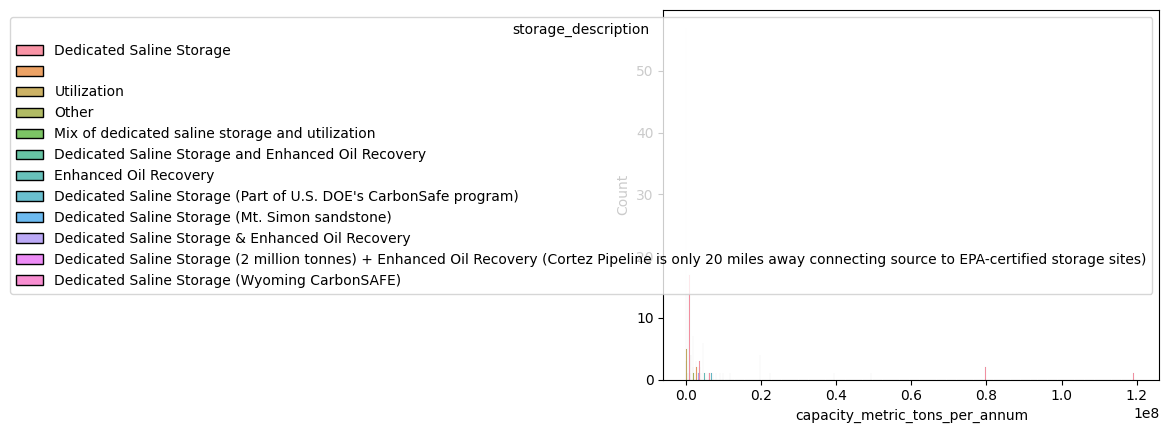

In [265]:
sns.histplot(
    data=catf_df,
    x="capacity_metric_tons_per_annum",
    hue="storage_description",
    multiple="dodge",
)

In [320]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 445 entries, 0 to 444
Data columns (total 25 columns):
 #   Column                                   Non-Null Count  Dtype  
---  ------                                   --------------  -----  
 0   category                                 322 non-null    object 
 1   status                                   321 non-null    object 
 2   operational                              322 non-null    float64
 3   industry                                 320 non-null    object 
 4   description                              445 non-null    object 
 5   operational_raw                          318 non-null    object 
 6   gci_name                                 323 non-null    object 
 7   iea_name                                 313 non-null    object 
 8   id                                       296 non-null    float64
 9   partners                                 296 non-null    object 
 10  project_type                             296 non-n

In [305]:
df[["estimated_capacity_by_iea_mt_co2_per_yr", "project_status", "eor"]].groupby(
    ["project_status", "eor"]
).sum()

estimated_capacity_by_iea_mt_co2_per_yr
project_status                     eor                                         
Operational                        0                                      1.062
                                   1                                     20.720
Planned                            0                                    769.341
                                   1                                    134.060
Suspended/cancelled/decommissioned 0                                      0.330
                                   1                                      3.000
Under construction                 0                                     13.650
                                   1                                      1.360

In [363]:
catf_df["eor"] = [1 if x == "eor" else 0 for x in catf_df.storage_type]
catf_df["status"] = [
    "In Development" if x == "Under Construction" else x for x in catf_df.status
]
catf_df["capacity_mt_co2_per_yr"] = [
    x / 1e6 for x in catf_df.capacity_metric_tons_per_annum
]

In [368]:
catf_df

,project_name,entities,capture_or_storage_details,country,location,state,sector_classification,sector_description,subsector_classification,subsector_description,...,storage_description,year_announced,year_operational,status,notes,month_announced,reference,storage_type,eor,capacity_mt_co2_per_yr
0,Houston Ship Channel CCS Innovation Zone,Exxon,Offshore storage,United States,Houston TX,TX,Industrial,Industrial,Storage,Storage,...,Dedicated Saline Storage,2021.0,NaN,In Development,Once it is fully online sequestering 100 milli...,NaN,https://www.forbes.com/sites/davidblackmon/202...,gs,0,NaN
1,Northern Delaware Basin/Red Hills,Lucid Energy Group/Targa Resources,What would be the Permian Basin's largest CCS ...,United States,Lea County NM,NM,Power,Power,Gas Processing,Gas Processing,...,Dedicated Saline Storage,2022.0,NaN,In Development,NaN,Jan-22,https://www.energyintel.com/0000017e-5a3e-df72...,gs,0,0.50
2,Baytown Low Carbon Hydrogen Project,ExxonMobil Technip Energies,Low-carbon hydrogen ammonia and carbon capture...,United States,Baytown TX,TX,Industrial,Industrial,Hydrogen,Hydrogen,...,Dedicated Saline Storage,2022.0,2027,In Development,Currently in DOE FEED stage (January 2023),Mar-22,https://corporate.exxonmobil.com/news/newsroom...,gs,0,10.00
3,Project Cyclus,Babcock & Wilcox Kiewit CSRS Fidelis,Net-Negative CO2 Biomass-to-Energy Facility fo...,United States,West Baton Rouge Parish LA,LA,Power,Power,Waste-to-Energy,Waste-to-Energy,...,,2022.0,NaN,In Development,NaN,Mar-22,https://www.businesswire.com/news/home/2022033...,,0,2.00
4,El Dorado,Lapis Energy LSB Industries,Capture on blue ammonia production with storag...,United States,El Dorado AR,AR,Industrial,Industrial,Ammonia,Ammonia,...,Dedicated Saline Storage,2022.0,NaN,In Development,First CO2 injection expected by 2025,4/1/22,https://lapisenergy.com/lapis-energy-to-develo...,gs,0,0.45
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
220,Blue Point Complex,CF Industries POSCO JERA Mitsui,CF Industries is in the early development stag...,United States,Ascension Parish LA,LA,Industrial,Industrial,Ammonia,Ammonia,...,Dedicated Saline Storage,2022.0,NaN,In Development,CF is exploring multiple projects for blue amm...,Sep-24,https://www.cfindustries.com/newsroom/2024/cf-...,gs,0,0.85
221,Grön Fuels,Grön Fuels Fidelis Babcock & Wilcox,65000 BPD renewable fuels facility with plans ...,United States,Port Allen LA,LA,Industrial,Industrial,Biofuels,Low carbon fuels,...,Dedicated Saline Storage,2020.0,2030,In Development,"LED page states ""the complex can store an esti...",Sep-24,https://www.opportunitylouisiana.gov/project/g...,gs,0,NaN
222,Project Tundra,Minnkota Power Cooperative TC Energy Mitsubish...,Project will capture up to ~4 million tons of ...,United States,Oliver County ND,ND,Power,Power,Coal,Coal-fired power plant,...,Dedicated Saline Storage,2023.0,2029,In Development,Award funding in 2023 via OCED's CC demos program,Oct-24,OCED announcement: https://www.energy.gov/oced...,gs,0,4.00
223,Four Corners Power Plant,Navajo Transitional Energy Company (NTEC),FEED study funding awarded to NTEC for carbon ...,United States,Kirtland NM,NM,Power,Power,Coal,Coal-fired power plant,...,Dedicated Saline Storage,2024.0,NaN,In Development,NaN,Oct-24,https://nmpoliticalreport.com/news/ntec-receiv...,gs,0,1.00


In [424]:
plot_df = (
    catf_df[
        [
            "capacity_mt_co2_per_yr",
            # "sector_classification",
            "subsector_classification",
            "status",
            "eor",
        ]
    ]
    .loc[[x != "CO2 pipeline" for x in catf_df.subsector_description]]
    .groupby(
        [
            "eor",
            "status",
            # "sector_classification",
            "subsector_classification",
        ]
    )
    .sum()
    .reset_index()
)
plot_df.columns = [
    "EOR",
    "status",
    "subsector_classification",
    "capacity_mt_co2_per_yr",
]
plot_df.EOR = plot_df.EOR.astype(bool)

In [434]:
plot_df[["EOR", "subsector_classification", "capacity_mt_co2_per_yr"]].loc[
    plot_df.status == "In Development"
].groupby(["EOR", "subsector_classification"]).sum().reset_index().pivot(
    columns="EOR", index="subsector_classification"
).to_clipboard()

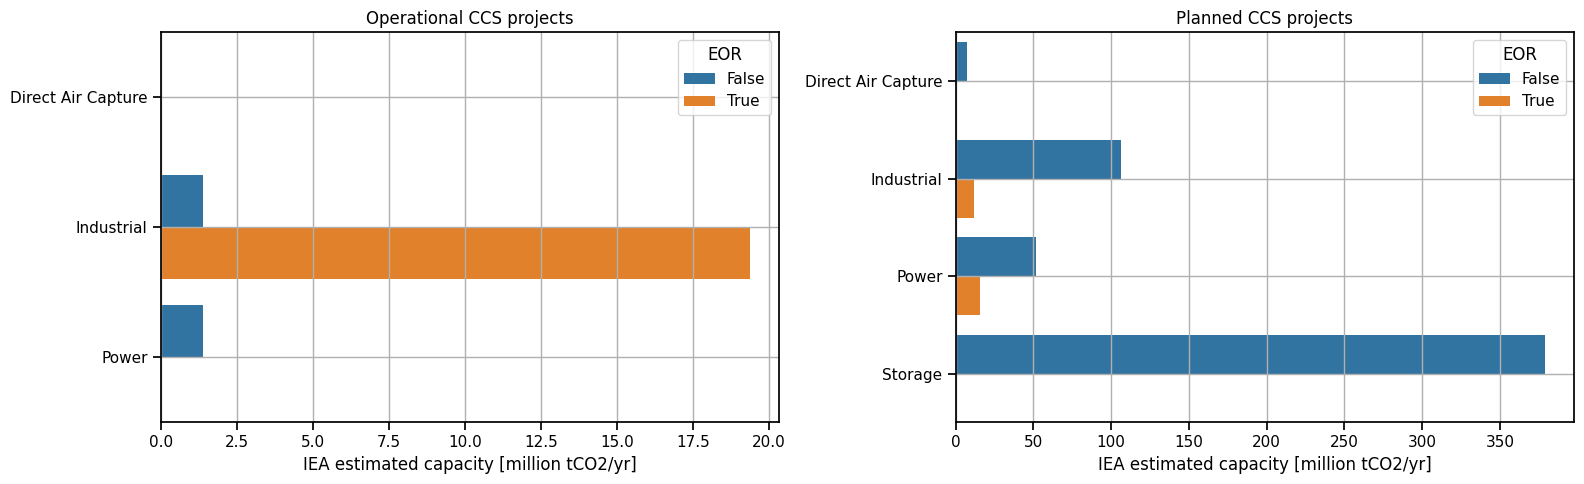

In [418]:
sns.set_context("notebook")
fig, ax = plt.subplots(1, 2, figsize=(16, 5))
sns.barplot(
    data=plot_df.loc[plot_df.status == "Operational"],
    y="sector_classification",
    x="capacity_mt_co2_per_yr",
    hue="EOR",
    ax=ax[0],
)
ax[0].set_title("Operational CCS projects")

sns.barplot(
    data=plot_df.loc[plot_df.status == "In Development"],
    y="sector_classification",
    x="capacity_mt_co2_per_yr",
    hue="EOR",
    ax=ax[1],
)
ax[1].set_title("Planned CCS projects")
for i in range(2):
    ax[i].grid()
    ax[i].set_xlabel("IEA estimated capacity [million tCO2/yr]")
    ax[i].set_ylabel("")
fig.tight_layout()

In [412]:
catf_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 225 entries, 0 to 224
Data columns (total 25 columns):
 #   Column                                     Non-Null Count  Dtype  
---  ------                                     --------------  -----  
 0   project_name                               225 non-null    object 
 1   entities                                   225 non-null    object 
 2   capture_or_storage_details                 222 non-null    object 
 3   country                                    225 non-null    object 
 4   location                                   221 non-null    object 
 5   state                                      221 non-null    object 
 6   sector_classification                      225 non-null    object 
 7   sector_description                         225 non-null    object 
 8   subsector_classification                   225 non-null    object 
 9   subsector_description                      225 non-null    object 
 10  approx_latitude                

In [414]:
catf_df[
    [
        "project_name",
        "location",
        "capacity_mt_co2_per_yr",
        "subsector_description",
        "year_operational",
        "status",
    ]
].loc[
    (catf_df.capacity_mt_co2_per_yr.notna())
    & (catf_df.subsector_description != "CO2 pipeline")
].sort_values(
    by="capacity_mt_co2_per_yr", ascending=False
)

,project_name,location,capacity_mt_co2_per_yr,subsector_description,year_operational,status
216,Carbon Terravault II & III,Sacramento CA,80.0000,Storage,NaN,In Development
217,Denbury Donaldsonville,Donaldsonville LA,80.0000,Storage,NaN,In Development
213,HERO Basalt CarbonSAFE,Hermiston OR,50.0000,Storage,NaN,In Development
205,Carbon Terravault I,Bakersfield CA,40.0000,Storage,NaN,In Development
43,Project Crossroads,Whiting IN,23.0000,Oil,NaN,In Development
...,...,...,...,...,...,...
152,Project Bantam DAC,Osage County OK,0.0070,Direct Air Capture,2025,In Development
154,University of Illinois,Gary IN,0.0050,Direct Air Capture,NaN,In Development
153,Farley Nuclear DAC Project,Columbia AL,0.0050,Direct Air Capture,NaN,In Development
155,Heirloom DAC Facility,Tracy CA,0.0010,Direct Air Capture,2023,Operational


In [342]:
catf_df.loc[catf_df.capacity_mt_co2_per_yr.notna()].to_clipboard()

In [352]:
subset_df = df.loc[(df.estimated_capacity_by_iea_mt_co2_per_yr.notna())]
subset_df["iea_name"] = subset_df.iea_name.fillna("")

In [347]:
subset_df

,category,status,operational,industry,description,operational_raw,gci_name,iea_name,id,partners,...,project_status,project_phase,announced_capacity_mt_co2_per_yr,estimated_capacity_by_iea_mt_co2_per_yr,sector,fate_of_carbon,part_of_ccus_hub,region,references,eor
3,Commercial CCS Facility,Advanced Development,2025.0,CO2 Transport / Storage,The Archer Daniels Midland (ADM) plans to expa...,2025,Maroa (Decatur Addition),ADM Decatur Campus CO2 Storage Site Expansion ...,816.0,ADM,...,Planned,2.0,2.95,2.950,T&S,Dedicated storage,ADM Decatur Campus CO2 Storage Site Expansion ...,North America,nan nan nan nan nan nan nan,0
4,Commercial CCS Facility,Advanced Development,2025.0,CO2 Transport / Storage,The Archer Daniels Midland (ADM) plans to expa...,2025,Maroa (Decatur Addition),ADM Maroa/Forsyth CO2 Storage Site Development...,869.0,ADM,...,Planned,NaN,3.3,3.300,Storage,Unknown/unspecified,Maroa (IL),North America,https://www.epa.gov/uic/current-class-vi-proje...,0
5,Commercial CCS Facility,Early Development,2033.0,Power Generation and Heat,The Ackerman Combined Cycle Carbon Capture is ...,Under Evaluation,Ackerman CCS,Ackerman Combined Cycle Plant (MS),975.0,"Trifecta Renewable Solutions, Tennessee Valley...",...,Planned,NaN,1.8,1.800,Power and heat,Dedicated storage,Red Hills CO2 storage hub (MS),North America,https://www.energy.gov/fecm/project-selections...,0
6,NaN,NaN,NaN,NaN,,NaN,NaN,NaN,1033.0,"Adams Fork Energy, the Flandreau Santee Sioux ...",...,Planned,NaN,NaN,3.591,Hydrogen or ammonia,Unknown/unspecified,NaN,North America,https://adamsforkenergy.com/ https://investors...,0
8,NaN,NaN,NaN,NaN,,NaN,NaN,Advanced CO2 Capture from Hydrogen Production ...,695.0,Phillips 66,...,Planned,NaN,0.19,0.190,Other fuel transformation,Unknown/unspecified,NaN,North America,https://www.netl.doe.gov/node/10875 nan nan na...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
318,Commercial CCS Facility,Early Development,2033.0,CO2 Transport / Storage,The Virginia CarbonSAFE Storage project in Wis...,Under Evaluation,Virginia CarbonSafe storage,Virginia CarbonSafe storage (VA),971.0,The Commonwealth of Virginia DoE (Big Stone Gap),...,Planned,NaN,4,4.000,Storage,Dedicated storage,Virginia CarbonSafe storage (VA),North America,https://www.energy.gov/fecm/project-selections...,0
319,Commercial CCS Facility,Early Development,2026.0,CO2 Transport / Storage,Denbury Virgo Sequestration Site is part of th...,2026,Virgo Sequestration Site,Virgo (LA),885.0,ExxonMobil (formerly Denbury carbon solutions),...,Planned,NaN,5 - 10,5.000,Storage,Unknown/unspecified,NaN,North America,https://www.denbury.com/operations/carbon-solu...,0
321,Commercial CCS Facility,Advanced Development,2026.0,Hydrogen / Ammonia / Fertiliser,Wabash Valley Resources LLC aims to develop a ...,2026,Wabash Valley Resources West Terre Haute ferti...,Wabash Valley Resources/Wabash CarbonSAFE (IN),406.0,"Wabash Valley Resources, Wabash Carbon service...",...,Planned,NaN,1.65,1.650,Hydrogen or ammonia,Dedicated storage,Wabash CarbonSAFE (IN),North America,https://www.netl.doe.gov/projects/project-info...,0
324,Commercial CCS Facility,Early Development,2033.0,CO2 Transport / Storage,The Williams Echo Springs CarbonSAFE Storage C...,Under Evaluation,William Echo Springs CarbonSAFE,William Echo Springs CarbonSAFE (WY),959.0,"University of Wyoming, Williams",...,Planned,NaN,NaN,1.667,Storage,Dedicated storage,William Echo Springs CarbonSAFE (WY),North America,https://www.uwyo.edu/ser/news/2023/11/echo-spr...,0


In [316]:
catf_df[["eor", "capacity_mt_co2_per_yr", "status"]].groupby(["status", "eor"]).sum()

capacity_mt_co2_per_yr
status             eor                        
In Development     0                675.884789
                   1                 27.687865
Operational        0                  2.781000
                   1                 19.360000
Under Construction 0                  0.000000

In [294]:
for i in sorted(
    list(
        catf_df["project_name"].loc[["Biorefinery" in x for x in catf_df.project_name]]
    )
):
    print(f"{i}")

Aberdeen Biorefinery
Atkinson Biorefinery
Casselton Biorefinery
Fairmont Biorefinery
Galva Biorefinery
Goldfield Biorefinery
Grand Junction Biorefinery
Granite Falls Biorefinery
Heron Lake Biorefinery
Huron Biorefinery
Lamberton Biorefinery
Lawler Biorefinery
Madison Biorefinery
Marcus Biorefinery
Mason City Biorefinery
Merrill Biorefinery
Mina Biorefinery
Mount Vernon Biorefinery
Nevada Biorefinery
Norfolk Biorefinery
Onida Biorefinery
Otter Tail Biorefinery
Plainview Biorefinery
Redfield Biorefinery
Shenandoah Biorefinery
Sioux Center Biorefinery
Steamboat Rock Biorefinery
Superior Biorefinery
Watertown Biorefinery
Wentworth Biorefinery
Wood River Biorefinery
York Biorefinery


In [197]:
for v in [
    "visualized_capacity_metric_tons_per_annum",
    "capacity_metric_tons_per_annum",
    "approx_latitude",
    "approx_longitude",
]:
    catf_df[v] = catf_df[v].replace("-\xa0", np.nan)
    catf_df[v] = catf_df[v].astype(float)

In [205]:
catf_df.columns.values

array(['project_name', 'entities', 'capture_or_storage_details',
       'country', 'location', 'state', 'sector_classification',
       'sector_description', 'subsector_classification',
       'subsector_description', 'approx_latitude', 'approx_longitude',
       'visualized_capacity_metric_tons_per_annum',
       'capacity_metric_tons_per_annum', 'storage_classification',
       'storage_description', 'year_announced', 'year_operational',
       'status', 'notes', 'month_announced', 'reference'], dtype=object)

In [206]:
catf_df.storage_description.value_counts(dropna=False)

storage_description
Dedicated Saline Storage                                                                                                                                        157
NaN                                                                                                                                                              26
Enhanced Oil Recovery                                                                                                                                            25
Utilization                                                                                                                                                       7
Other                                                                                                                                                             2
Dedicated Saline Storage (Part of U.S. DOE's CarbonSafe program)                                                                                                

In [201]:
catf_df.loc[
    catf_df["storage_classification"] == "Dedicated Saline Storage"
].capture_or_storage_details.values

array(['Offshore storage',
       "What would be the Permian Basin's largest CCS project Lucid purchased by Targa in July 2022",
       'Low-carbon hydrogen ammonia and carbon capture facility is expected to produce one billion cubic feet of low-carbon hydrogen per day making it the largest low-carbon hydrogen project in the world at planned startup in 2027-2028',
       'Net-Negative CO2 Biomass-to-Energy Facility for Fidelis New Energy Using B&W’s Advanced Biomass and Proprietary OxyBright™ Carbon Capture Technologies',
       'Capture on blue ammonia production with storage below the facility',
       'Designed to achieve at least a 90 percent reduction in CO2 emissions',
       'Cameron LNG Phase 1 and proposed Phase 2 export projects would potentially serve as the anchor source for the capture and sequestration of carbon dioxide',
       "Capture and transport carbon dioxide produced at ADM's ethanol facilities at Clinton and Cedar Rapids Iowa.",
       'CO2 capture from natural g

In [177]:
catf_df.columns

Index(['project_name', 'entities', 'capture_or_storage_details', 'country',
       'location', 'state', 'sector_classification', 'sector_description',
       'subsector_classification', 'subsector_description', 'approx_latitude',
       'approx_longitude', 'visualized_capacity_metric_tons_per_annum ',
       'capacity_metric_tons_per_annum ', 'storage_classification',
       'storage_description', 'year_announced', 'year_operational', 'status',
       'notes', 'month_announced', 'reference', 'unnamed:_22', 'unnamed:_23'],
      dtype='object')